<a href="https://colab.research.google.com/github/Nabeel-Jo/nst/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Neural Style Transfer (NST)**

Implemented from [Aladdin Persson's video on NST](https://youtu.be/imX4kSKDY7s)


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image
from PIL import Image

Model

In [2]:
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.chosen_features = [0, 5, 10, 19, 28]
    self.model = models.vgg19(pretrained=True).features[:29]

  def forward(self, x):
    features = []
     
    for layer_num, layer in enumerate(self.model):
      x = layer(x)

      if layer_num in self.chosen_features:
        features.append(x)

    return features

In [3]:
model = models.vgg19(pretrained=True).features[:29]
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Hyperparameters

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = 512
total_steps = 500
lr = 0.02
alpha = 1e4
beta = 1e-2

Image Loader

In [6]:
loader = transforms.Compose(
    [
      transforms.Resize((img_size, img_size)),
      transforms.ToTensor(),
    ]
)

def load_image(image_name):
  img = Image.open(image_name).convert('RGB')
  img = loader(img).unsqueeze(0)
  return img.to(device)

Train function

In [7]:
def train(model, optim, orig_img, gen_img, style_img):
    for _ in tqdm_notebook(range(total_steps)):
        orig_features = model(orig_img)
        gen_features = model(gen_img)
        style_features = model(style_img)

        content_loss = style_loss = 0

        for gen_feat, orig_feat, style_feat in zip(gen_features, orig_features, style_features):
            batch, channel, height, width = gen_feat.shape
            content_loss += torch.mean((gen_feat - orig_feat) ** 2)

            G = gen_feat.view(channel, height * width).mm(gen_feat.view(channel, height * width).t())
            A = style_feat.view(channel, height * width).mm(style_feat.view(channel, height * width).t())

            style_loss += torch.mean((G - A) ** 2)

        total_loss = alpha * content_loss + beta * style_loss
        optim.zero_grad()
        total_loss.backward()
        optim.step()

    return [content_loss, style_loss, total_loss], gen_img

Input and Style Image

In [8]:
original_image = load_image('/content/Timmy.jpg')
style_img = load_image('/content/VanGogh.jpg')
generated_image = original_image.clone().requires_grad_(True)

In [9]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = torch.squeeze(image, axis=0)
  
  image = image.cpu().detach().numpy()
  image = image.transpose(1, 2, 0)
  
  plt.imshow(image, )
  if title:
    plt.title(title)

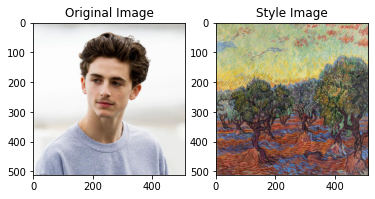

In [10]:
plt.subplot(1, 2, 1)
imshow(original_image, "Original Image")

plt.subplot(1, 2, 2)
imshow(style_img, "Style Image")

In [15]:
optimizer = optim.Adam([generated_image], lr=lr, eps=1e-1)
model = VGG().to(device).eval()

loss, output = train(model, optimizer, original_image, generated_image, style_img)

print("Content Loss: ", loss[0])
print("Style Loss: ", loss[1])
print("Total Loss: ", loss[2])

save_image(output, "generated_1.jpg")

  0%|          | 0/500 [00:00<?, ?it/s]

Content Loss:  tensor(4.4250, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss:  tensor(1380947.2500, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss:  tensor(58059.1016, device='cuda:0', grad_fn=<AddBackward0>)


Output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


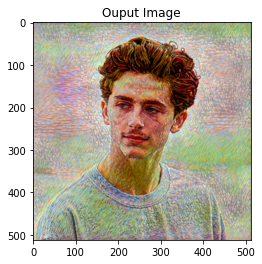

In [16]:
imshow(output, "Ouput Image")

In [17]:
original_image = load_image('/content/Margot.jpg')
style_img = load_image('/content/Picasso.jpg')
generated_image = original_image.clone().requires_grad_(True)

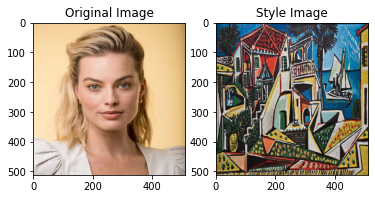

In [18]:
plt.subplot(1, 2, 1)
imshow(original_image, "Original Image")

plt.subplot(1, 2, 2)
imshow(style_img, "Style Image")

In [19]:
optimizer = optim.Adam([generated_image], lr=lr, eps=1e-1)
model = VGG().to(device).eval()

loss, output = train(model, optimizer, original_image, generated_image, style_img)

print("Content Loss: ", loss[0])
print("Style Loss: ", loss[1])
print("Total Loss: ", loss[2])

save_image(output, "generated_2.jpg")

  0%|          | 0/500 [00:00<?, ?it/s]

Content Loss:  tensor(23.0506, device='cuda:0', grad_fn=<AddBackward0>)
Style Loss:  tensor(5077469., device='cuda:0', grad_fn=<AddBackward0>)
Total Loss:  tensor(281280.2500, device='cuda:0', grad_fn=<AddBackward0>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


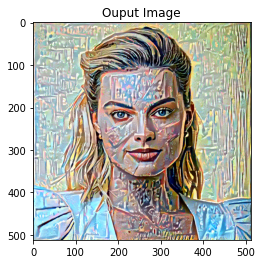

In [20]:
imshow(output, "Ouput Image")